In [3]:
import sys
import torch
import numpy as np
import torch
import traci
from sumolib import checkBinary
import torch
import sys
import os
from utils import *
import copy
import gym
import random
from Models import GRUModel, SAGE_GDQN_Attention, JK_SAGE_GDQN_Attention
from Envs import *
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F
import pandas as pd
import math
import torch.optim as optim
from Knowledges import *
from SentHistory import *
import torch.nn as nn
from torch_geometric.data import Batch
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

# sumoBinary = checkBinary('sumo-gui')
sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


In [4]:
def connectivity(xs,ys, threshold=800):
    xs = torch.tensor(xs, dtype=torch.float32).view(-1,1)
    ys = torch.tensor(ys, dtype=torch.float32).view(-1,1)
    intervehicle_distances = torch.sqrt((xs - xs.t())**2 + (ys - ys.t())**2)
    if threshold is not None:
        # make the distances 1 if less than the threshold, 0 otherwise
        connectivity = torch.where(intervehicle_distances < threshold, torch.ones_like(intervehicle_distances), torch.zeros_like(intervehicle_distances))
    connectivity = connectivity - torch.diag(torch.diag(connectivity))
    return connectivity, xs, ys

In [12]:
class Incomplete_Routing_Gym(gym.Env):
    def __init__(self, sumoCmd, model, max_steps=1100, n_nodes=57, max_routing_steps=30, max_n_neighbors=6):
        self.sumoCmd = sumoCmd
        self.step_counter = 0
        self.max_steps = max_steps
        self.n_nodes = n_nodes
        self.start_node = None
        self.end_node = None
        self.current_node = None
        self.node_features = None
        self.adj_matrix = None
        self.edge_index = None
        self.hop_thresh = None
        self.routing_done = False
        self.routing_steps = 0
        self.min_n_hops = None
        self.end_node_indicator = torch.zeros(n_nodes)
        self.max_routing_steps = max_routing_steps
        self.n_hop_matrix = None
        self.neighbors_indicator = None
        self.action_space = None
        self.to_remove_indices = None
        self.prunned_adj_matrix = None
        self.prunned_n_hop_matrix = None
        self.state = None
        self.max_n_neighbors = max_n_neighbors
        self.ids = None
        self.vehicle_knowledges = {}
        self.vehicle_records = {}
        self.GRUModel = model
        self.GRUModel.eval()

        self.cached_states = {}

        self.xs = None
        self.ys = None
        self.start_x = None
        self.start_y = None
        self.end_x = None
        self.end_y = None

        self.total_missing_ratio = 0
        self.total_error = 0
        self.total_num_graphs = 0

        self.delay_distribution = []

        self.observed_adj_matrix = None
        self.observed_n_hop_matrix = None

        self.trajectory_dict = {}


        self.load_all_trajectory()

        self.destination_unknown = False

    

    def load_all_trajectory(self):
        self.checkpoints_dict = get_planned_path()
        checkpoints = list(self.checkpoints_dict.values())
        checkpoints = torch.tensor(checkpoints).float() / 10
        position_df = pd.read_csv('trajectory_time.csv')
        position_df.set_index('Unnamed: 0', inplace=True)
        position_array = position_df.to_numpy()
        sequence_length = position_df.shape[1] // 2
        tensor_list = []

        for row in position_array:
            reshaped_tensor = torch.tensor(row.reshape(sequence_length, 2))
            tensor_list.append(reshaped_tensor)

        all_trajectories_tensor = torch.stack(tensor_list).float() / 10

        next_checkpoint = torch.zeros_like(all_trajectories_tensor)
        next_next_checkpoint = torch.zeros_like(all_trajectories_tensor)
        checkpoints_pad_1 = F.pad(checkpoints, (0, 0, 1, 0))
        for i in range(all_trajectories_tensor.shape[1]):
            _, min_indices = project_to_nearest(all_trajectories_tensor[:, i], checkpoints)
            next_checkpoint[:, i] = checkpoints_pad_1[range(checkpoints.shape[0]), min_indices+1]
            next_next_checkpoint[:, i] = checkpoints_pad_1[range(checkpoints.shape[0]), min_indices+2]

        all_trajectories_tensor = torch.cat((all_trajectories_tensor, next_checkpoint, next_next_checkpoint), dim=2)

        # convert all_trajectories_tensor to a dictionary, where keys are the vehicle ids
        for i, n in enumerate(position_df.index):
            self.trajectory_dict[str(n)] = all_trajectories_tensor[i]
            self.checkpoints_dict[str(n)] = checkpoints[i]

    def reset(self):
        try:
            traci.close()
        except:
            pass
        traci.start(self.sumoCmd)
        self.step_counter = traci.simulation.getTime()

        while self.step_counter < 400:
            self.simstep_with_sync()


    def node_pruning(self):
        self.prunned_adj_matrix = copy.deepcopy(self.observed_adj_matrix)
        self.prunned_n_hop_matrix = copy.deepcopy(self.observed_n_hop_matrix)
        neighbor_indices = np.where(self.observed_adj_matrix[self.current_node] == 1)[0]
        if len(neighbor_indices) >= self.max_n_neighbors:
            two_hop_neighbours_indices = np.where(self.observed_n_hop_matrix[self.current_node] == 2)[0]
            two_hop_neighbours_mask = (self.observed_n_hop_matrix[self.current_node] == 2).type(torch.int)
            # direct neighbours connectivities with two hop neighbours
            neighbour_dict = {}
            for neighbour_index in neighbor_indices:
                neighbour_dict[neighbour_index] = two_hop_neighbours_indices[np.where(self.observed_adj_matrix[neighbour_index][two_hop_neighbours_indices] == 1)[0]]
            # sort by the number of two hop neighbours
            neighbour_dict = dict(sorted(neighbour_dict.items(), key=lambda item: len(item[1]), reverse=True))

            self.to_remove_indices = []
            action_space = 0
            for neighbour_index, two_hop_neighbours_indices in neighbour_dict.items():
                mask_sum_before = torch.sum(two_hop_neighbours_mask)
                two_hop_neighbours_mask[two_hop_neighbours_indices] = 0
                mask_sum_after = torch.sum(two_hop_neighbours_mask)
                if mask_sum_after < mask_sum_before:
                    action_space += 1
                else:
                    self.to_remove_indices.append(neighbour_index)
            if action_space < self.max_n_neighbors:
                self.to_remove_indices = random.sample(self.to_remove_indices, len(self.to_remove_indices) - (self.max_n_neighbors - action_space))
            self.prunned_adj_matrix[self.to_remove_indices, :] = 0
            self.prunned_adj_matrix[:, self.to_remove_indices] = 0
            self.prunned_n_hop_matrix[self.to_remove_indices, :] = -100
            self.prunned_n_hop_matrix[:, self.to_remove_indices] = -100
        self.prunned_n_hop_matrix = self.prunned_n_hop_matrix - torch.diag(torch.diag(self.prunned_n_hop_matrix))
        self.prunned_adj_matrix = self.prunned_adj_matrix - torch.diag(torch.diag(self.prunned_adj_matrix))


    def next_episode(self, refresh=False):
        self.destination_unknown = False
        self.routing_done = False
        self.routing_steps = 0
        if not refresh:
            self.simstep_with_sync()
            self.adj_matrix = F.pad(self.adj_matrix, (0, self.n_nodes - self.adj_matrix.size(0), 
                                                  0, self.n_nodes - self.adj_matrix.size(1)), "constant", 0)
            self.n_hop_matrix = F.pad(self.n_hop_matrix, (0, self.n_nodes - self.n_hop_matrix.size(0), 
                                                      0, self.n_nodes - self.n_hop_matrix.size(1)), "constant", -100)
        self.select_start_end_nodes()
        self.current_node = self.start_node
        self.get_state()
        return copy.deepcopy(self.state)

    def simstep_with_sync(self):
        traci.simulationStep()
        self.cached_states = {}
        self.step_counter = int(traci.simulation.getTime())
        self.adj_matrix, self.xs, self.ys = intervehicleConnectivity_xs_ys(800)
        self.n_hop_matrix = bfs_distance(self.adj_matrix)
        self.ids = traci.vehicle.getIDList()
        action_spaces = self.adj_matrix - torch.diag(torch.diag(self.adj_matrix))

        for i, vehicle in enumerate(self.ids):
            if vehicle not in self.vehicle_knowledges:
                self.vehicle_knowledges[vehicle] = Knowledges()
            if vehicle not in self.vehicle_records:
                self.vehicle_records[vehicle] = Vehicle()
            self.vehicle_knowledges[vehicle].add_observations(self.ids, self.adj_matrix[i])
        
        for i, vehicle in enumerate(self.ids):
            non_zero_indices = torch.where(action_spaces[i] == 1)[0]
            neighbors = [self.ids[j] for j in non_zero_indices] 
            if len(neighbors) > 0:
                select_neighbour = self.vehicle_records[vehicle].select(neighbors)
                if select_neighbour is None:
                    continue
                self.vehicle_records[vehicle].send(select_neighbour)
                self.vehicle_knowledges[select_neighbour].merge_knowledges(self.vehicle_knowledges[vehicle].get_knowledges(), self.vehicle_knowledges[vehicle].get_delays())

                self.vehicle_records[select_neighbour].send(vehicle)
                self.vehicle_knowledges[vehicle].merge_knowledges(self.vehicle_knowledges[select_neighbour].get_knowledges(), self.vehicle_knowledges[select_neighbour].get_delays())
            
        for vehicle in self.vehicle_records.values():
            vehicle.step()

        
    def select_start_end_nodes(self):
        self.hop_thresh = min(self.n_hop_matrix.max(), 5)
        starts, ends = torch.where(self.hop_thresh == self.n_hop_matrix)
        starts = starts.tolist()
        ends = ends.tolist()
        self.start_node, self.end_node = random.choice(list(zip(starts, ends)))
        # minimal number of hops between start and end nodes
        self.min_n_hops = self.n_hop_matrix[self.start_node, self.end_node]

        self.start_x = self.xs[self.start_node]
        self.start_y = self.ys[self.start_node]
        self.end_x = self.xs[self.end_node]
        self.end_y = self.ys[self.end_node]

    
    def get_state(self):
        if self.current_node in self.cached_states:
            self.state = copy.deepcopy(self.cached_states[self.current_node])
        self.compute_state()
        self.cached_states[self.current_node] = copy.deepcopy(self.state)
    

    def compute_state(self):
        current_vehicle_knowledge = self.vehicle_knowledges[self.ids[self.current_node]].get_knowledges()
        current_vehicle_delay = self.vehicle_knowledges[self.ids[self.current_node]].get_delays()
        observed_vehicle_xs = []
        observed_vehicle_ys = []
        for vehicle in self.ids:
            if current_vehicle_delay[vehicle] == 0:
                observed_vehicle_xs.append(self.xs[self.ids.index(vehicle)])
                observed_vehicle_ys.append(self.ys[self.ids.index(vehicle)])
            elif current_vehicle_delay[vehicle] >= 10 or sum(current_vehicle_knowledge[vehicle]) <= 3:
                observed_vehicle_xs.append(0)
                observed_vehicle_ys.append(0)
            else:
                x, y = self.estimate_vehicle_positions(vehicle, current_vehicle_knowledge[vehicle], current_vehicle_delay[vehicle])
                observed_vehicle_xs.append(x)
                observed_vehicle_ys.append(y)
        
        self.observed_adj_matrix, xs, ys = connectivity(observed_vehicle_xs, observed_vehicle_ys)
        # set connectivity to 0 if the vehicle is not observed
        not_observed_indices = torch.where(xs == -1)[0]
        self.observed_adj_matrix[not_observed_indices, :] = 0
        self.observed_adj_matrix[:, not_observed_indices] = 0

        self.observed_adj_matrix = F.pad(self.observed_adj_matrix, (0, self.n_nodes - self.observed_adj_matrix.size(0), 
                                                  0, self.n_nodes - self.observed_adj_matrix.size(1)), "constant", 0)
        # set the neighbouring connectivity to the true connectivity
        non_neighbour_indices = torch.where(self.adj_matrix[self.current_node] == 0)[0]
        self.observed_adj_matrix[self.current_node, non_neighbour_indices] = 0
        self.observed_adj_matrix[non_neighbour_indices, self.current_node] = 0

        if xs[self.end_node] == 0 and ys[self.end_node] == 0:
            self.destination_unknown = True

        norm_xs = (xs - self.end_x) / (self.start_x - self.end_x)
        norm_ys = (ys - self.end_y) / (self.start_y - self.end_y)
        # set the norm_xs and norm_ys to 0 if the vehicle is not observed
        norm_xs[not_observed_indices] = 0
        norm_ys[not_observed_indices] = 0
        # padding the matrices to the same size
        norm_xs = F.pad(norm_xs, (0, 0, 0, self.n_nodes - norm_xs.size(0)), "constant", 0)
        norm_ys = F.pad(norm_ys, (0, 0, 0, self.n_nodes - norm_ys.size(0)), "constant", 0)
        self.observed_n_hop_matrix = bfs_distance(self.observed_adj_matrix)
        self.node_pruning()
        edge_index = dense_to_sparse(self.prunned_adj_matrix)[0]

        curr_node_indicator = torch.zeros(self.n_nodes)
        curr_node_indicator[self.current_node] = 1
        distances = self.prunned_n_hop_matrix[self.end_node]
        distances[distances == -100] = 8
        distances[distances > 7] = 7
        one_hot_distances = F.one_hot(distances.long(), num_classes=8).type(torch.float32)
        neighbour_indicator = self.prunned_adj_matrix[self.current_node]
        uncertainties_delay = torch.tensor([current_vehicle_delay[vehicle] for vehicle in self.ids]).unsqueeze(1) / 10
        uncertainties_delay = F.pad(uncertainties_delay, (0, 0, 0, self.n_nodes - uncertainties_delay.size(0)), "constant", 1)
        node_features = torch.cat((one_hot_distances, uncertainties_delay, self.end_node_indicator.unsqueeze(1), 
                                   curr_node_indicator.unsqueeze(1), neighbour_indicator.unsqueeze(1), 
                                   norm_xs, norm_ys), dim=1)
        self.state = Data(x=node_features, edge_index=edge_index).to(device)


    def act(self, neighbor_index):
        self.routing_steps += 1
        neighbors = torch.where(self.prunned_adj_matrix[self.current_node] == 1)[0]
        valid_action_size = len(neighbors)
        if valid_action_size <= neighbor_index:
            self.routing_done = self.routing_steps >= self.max_routing_steps
            if self.routing_done:
                return self.state, torch.tensor(-1).to(device), self.routing_done
            return self.state, torch.tensor(-0.15).to(device), self.routing_done
        else:
            next_hop = neighbors[neighbor_index]
            reward = self.compute_reward(next_hop)
            self.current_node = next_hop
            self.get_state()
            return self.state, torch.tensor(reward).to(device), self.routing_done

    
    def estimate_vehicle_positions(self, vehicle, observation_history, delay):
        last_seen_time = int(self.step_counter - delay)
        first_one_index = int(observation_history.index(1))
        sequence_length = min(len(observation_history) - first_one_index, 20)
        # these last seen value will be used to calibrate the position of the vehicle
        # we set the last seen value to 50, 50, as the autoregressive model is trained on the normalized values
        last_seen_x = self.trajectory_dict[vehicle][last_seen_time][0].item()
        last_seen_y = self.trajectory_dict[vehicle][last_seen_time][1].item()
        modif = (torch.tensor([last_seen_x, last_seen_y])-torch.tensor([50, 50])).repeat(1, 3)

        masks = torch.tensor(observation_history).unsqueeze(0).unsqueeze(2).repeat(1, 1, 6)

        paths = self.checkpoints_dict[vehicle].unsqueeze(0)
        inputs = copy.deepcopy(self.trajectory_dict[vehicle][self.step_counter-sequence_length+1:self.step_counter+1].unsqueeze(0))
        inputs -= modif
        masks = masks[:, -sequence_length:, :]
        modified_x, modified_y = self.GRU_inference(inputs.to(device), masks.to(device), paths.to(device))
        x, y = (modified_x + modif[0][0]).item() * 10, (modified_y + modif[0][1]).item() * 10
        return x, y
    

    def GRU_inference(self, inputs, masks, paths):
        with torch.no_grad():
            hidden = None
            seq_len = inputs.size(1)
            current_input = inputs[:, 0, :].unsqueeze(1)
            for t in range(1, seq_len):
                prediction, hidden = self.GRUModel(current_input, hidden)
                projection_with_checkpoints = project_to_nearest_with_checkpoints(prediction, paths)
                current_input = (projection_with_checkpoints * (1-masks[:, t, :]) + inputs[:, t, :] * (masks[:, t, :])).unsqueeze(1)
        return current_input[0,0,0], current_input[0,0,1]
    

    def compute_reward(self, next_hop):
        if self.routing_steps >= self.max_routing_steps:
            self.routing_done = True
            return -1
        elif self.adj_matrix[self.current_node, self.end_node] == 1:
            self.routing_done = True
            return (self.min_n_hops / self.routing_steps)
        elif self.n_hop_matrix[self.current_node, self.end_node] > self.n_hop_matrix[next_hop, self.end_node]:
            return 0.1
        else:
            return -0.15


    def get_action_mask(self):
        action_mask = copy.deepcopy(self.prunned_adj_matrix[self.current_node])
        action_mask = F.pad(action_mask, (0, self.n_nodes - action_mask.size(0)), "constant", 0).to(device)
        return action_mask


    def sim_done(self):
        """
        function: get the done state of simulation.
        """
        return not (shouldContinueSim() and self.step_counter < self.max_steps)


# Test the GRL on Env

In [13]:
def train():
    env.reset()
    done = False
    step_num = 0
    accumulated_rewards = []
    for i_episode in range(100):
        step_num += 1
        done = env.sim_done()
        state = env.next_episode()
        for i in range(200):
            state = env.next_episode(refresh=True)
            accumulated_reward = 0
            routing_done = False
            while not routing_done:
                action_mask = env.get_action_mask()

                shuffle_indices = torch.tensor([0, 1, 2, 3, 4, 5])
                action, use_policy = select_action(state, action_mask, shuffle_indices)

                if use_policy:
                    next_state, reward, routing_done = env.act(shuffle_indices[action.item()])
                else:
                    next_state, reward, routing_done = env.act(action.item())
                reward = torch.tensor([reward], device=device)
                accumulated_reward += reward.item()

                routing_done = routing_done

                if routing_done:
                    memory.push(state, action, None, reward, shuffle_indices)
                else:
                    memory.push(state, action, next_state, reward, shuffle_indices)

                # Move to the next state
                state = next_state

                optimize_model()
                if steps_done % 20 == 0:
                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    target_net.load_state_dict(target_net_state_dict)
            accumulated_rewards.append(accumulated_reward)
            if i == 190:
                print(f"Step: {step_num}, Iteration: {i}, Accumulated reward: {accumulated_reward}")
    return accumulated_rewards

In [14]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.2
EPS_END = 0.001
EPS_DECAY = 5000
TAU = 0.05
LR = 0.001

Transition = namedtuple('Transition',
                        ('data', 'action', 'next_state', 'reward', 'shuffle_indices'))


def select_action(data, action_mask, shuffle_indices):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.tensor([policy_net(data, shuffle_indices).max(1).indices.item()], device=device), True
    else:
        valid_size = len(torch.where(action_mask == 1)[0])
        return torch.randint(0, valid_size, (1,), device=device), False



def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = Batch.from_data_list([s for s in batch.next_state
                                                if s is not None])
    data_batch = Batch.from_data_list(batch.data)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.concat(batch.reward)
    shuffle_indices_batch = torch.stack(batch.shuffle_indices)

    state_action_values = policy_net(data_batch, shuffle_indices_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [15]:
n_nodes = 57
model = GRUModel(input_size=6, hidden_size=256, num_layers=2, output_size=2).to(device)
# load the model
model.load_state_dict(torch.load('models/gru_trajectory_prediction.pth'))
model.eval()
env = Incomplete_Routing_Gym(sumoCmd, model)
max_n_neighbors = 6

policy_net = SAGE_GDQN_Attention(in_channels=14, n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net = SAGE_GDQN_Attention(in_channels=14, n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0
# accumulated_rewards = train()

 Retrying in 1 seconds
***Starting server on port 39757 ***
Loading net-file from './config/osm.net.xml.gz' ... done (106ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 1557.00
Reason: TraCI requested termination.
Performance: 
 Duration: 0.40s
 TraCI-Duration: 0.25s
 Real time factor: 3921.91
 UPS: 115949.622166
Vehicles: 
 Inserted: 89
 Running: 0
 Waiting: 0
Statistics (avg of 89):
 RouteLength: 4885.02
 Speed: 9.58
 Duration: 517.21
 WaitingTime: 17.72
 TimeLoss: 70.09
 DepartDelay: 0.47



[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history')]

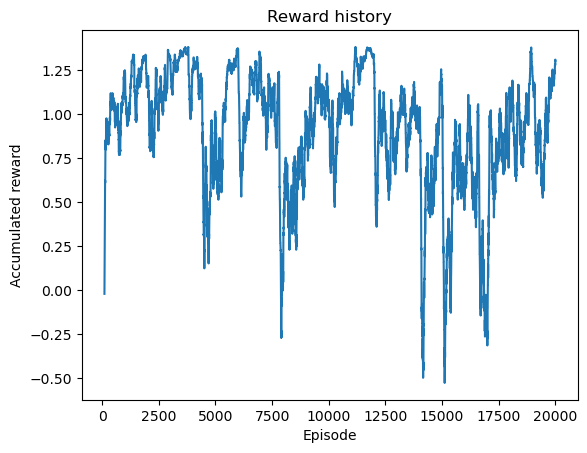

In [9]:
# # save reward history
# accumulated_rewards = pd.DataFrame(accumulated_rewards)
# print(accumulated_rewards)
# accumulated_rewards.to_csv('reward_history_SAGE_uncertain.csv', index=False)
# smooth the reward history
accumulated_rewards = accumulated_rewards.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(accumulated_rewards)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history')

In [8]:
# save the model
# torch.save(policy_net.state_dict(), 'models/SAGE_uncertain_policy.pth')
# torch.save(target_net.state_dict(), 'models/SAGE_uncertain_target.pth')

In [16]:
# load the model
policy_net.load_state_dict(torch.load('models/SAGE_uncertain_policy.pth'))
target_net.load_state_dict(torch.load('models/SAGE_uncertain_target.pth'))

<All keys matched successfully>

In [17]:
def test(iteration = 10):
    no_direct_path = 0
    total_tasks = 0
    total_reward = 0
    env.reset()
    accumulated_rewards = []
    done = False
    while not done:
        state = env.next_episode()
        print(env.step_counter)
        done = env.sim_done()
        for i in range(iteration):
            state = env.next_episode(refresh=True)
            total_tasks += 1
            accumulated_reward = 0
            routing_done = False
            skip = False
            while not routing_done:
                action_mask = env.get_action_mask()
                
                if env.destination_unknown:
                    skip = True
                    no_direct_path += 1
                    break
                shuffle_indices = torch.tensor([0, 1, 2, 3, 4, 5])
                action, use_policy = select_action(state, action_mask, shuffle_indices)
                node_features, reward, routing_done = env.act(action.item())
                reward = torch.tensor([reward], device=device)
                accumulated_reward += reward.item()

                routing_done = routing_done

                if routing_done:
                    next_state = None
                else:
                    next_state = node_features

                # Move to the next state
                state = next_state
            if not skip:
                accumulated_rewards.append(accumulated_reward)
                total_reward += accumulated_reward
    return accumulated_rewards, total_tasks, no_direct_path, total_reward

In [18]:
model.eval()
with torch.no_grad():
    test_rewards, total_tasks, no_direct_path, total_reward = test()
    print("Total tasks: ", total_tasks)
    print("No direct path: ", no_direct_path)
    print("Total reward: ", total_reward)
    test_rewards = np.array(test_rewards)
# save the test rewards
np.save("test_rewards_SAGE_uncertain.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

 Retrying in 1 seconds
***Starting server on port 50575 ***
Loading net-file from './config/osm.net.xml.gz' ... done (108ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
401


/tmp/ipykernel_27764/2091530876.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
